__Marketinganalyse__

Modulprojekt für die Vorlesung __Applied Statistics__

_Dozent:_ Prof. Dr. Jan Kirenz
_Studenten:_ Stephanie Flohr, Benedikt Haußner, Robert Masendorf

**Hinweis:** Zu korrekten Darstellung der Ergebnisse in den MarkDowns muss die Nbextension ```Python Markdown``` aktiviert sein. Zusätzlich muss ein ```Trusted```Kernel verwendet werden.

In [1]:
#import sys
#if not sys.warnoptions:
#import warnings
#warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set() 
%matplotlib inline 
plt.style.use('ggplot')
pd.set_option('display.max_columns',24)

# Ziel der Arbeit

Gute Note, rest egal.

__Regression__: CLV  
__Klassifikation__: Response

# Import data

Die von [hier](https://www.ibm.com/communities/analytics/watson-analytics-blog/marketing-customer-value-analysis/) verwendeten Daten wurden im März 2015 von der IBM als Beispieldatensatz unter dem Namen `SAMPLE DATA: Marketing Customer Value Analysis`veröffentlicht.

In [3]:
df = pd.read_csv('marketing_customer_marketing_raw_data.csv')

In [4]:
df.shape

(9134, 24)

In [5]:
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


# Understanding Columns  
**Customer_ID:**  
Eindeutig Kombination aus Buchstaben und Zahlen, zur Identifizierung des Kundens.  
  
**State:**  
Bundesstaat in den Vereinigten Staaten, in welchem der Kunde wohnt.  
  
**Customer_Lifetime_Value:**  
Durchschnittlicher Wert des Kundens für das Unternehmen während seines gesamten Lebenszyklus. Der Wert ist diskontiert auf den Betrachtungszeitpunkt.  
  
**Response:**  
Binärer Wert, ob der Kunde auf die Marketingmaßnahme reagiert hat.  
  
**Coverage:**  
Der aktuelle Tarif, in welchem sich der angesprochene Kunde befindet.  
  
**Education:**  
Der Bildungsstatus des angesprochenen Kunden.  
  
**Effective_To_Date:**  
Laufzeitende der aktuellen Versicherung.  
  
**Employment_Status:**  
Arbeitsverhältnis des Kundens.

**Gender:**  
Geschlecht des Kundens.  
  
**Income:**  
Jährliches Einkommen des Kundens in Dollar.  
  
**Location_Code:**  
Wohnumgebung des Kundens in Bezug auf die Flächenverdichtung.  
  
**Marital_Status:**  
Familienstand des Kundens.  
  
**Monthly_Premium_Auto:**  
Monatliche Versicherungsrate.  
  
**Months_Since_Last_Claim:**  
Vergangene Monate seit dem die Versicherung zuletzt in Anspruch genommen wurde.  
  
**Months_Since_Policy_Inception:**  
Vergangene Monate seit Beginn der aktuellen Verischerungspolice.  

**Number_of_Open_Complaints:**  
Anzahl der noch offenen Schadensfälle.  

**Number_of_Policies:**  
Gesamtanzahl der Policen seit Versicherungsbeginn.  
  
**Policy_Type:**  
Feststellung, ob es sich um eine private, eine geschäftliche oder eine Sonderpolice handelt.  
  
**Policy:**  
Akuelle Tarifstufe, in der der Kunde sich befindet.  
  
**Renew_Offer_Type:**  
Das dem Kunden unterbreitete neue Angebot.  
  
**Sales_Channel:**  
Der Kanal, über welchen das Angebot übermittelt wurde.  
  
**Total_Claim_Amount:**  
In Anspruch genommene Versicherungssumme.  
  
**Vehicle_Class:**  
Art des versicherten Autos.  
  
**Vehicle_Size:**  
Größenordnung des versicherten Autos.

# Tidying data

## Spalten bearbeiten

### Spalten umbenennen

In [6]:
df.columns

Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [7]:
# Change column name => some columns could not use
df = df.rename(index=str, columns={"Customer":"Customer_ID",
                                   "Customer Lifetime Value":"Customer_Lifetime_Value",
                                   "Effective To Date":"Effective_To_Date", 
                                   "EmploymentStatus":"Employment_Status", 
                                   "Location Code":"Location_Code", 
                                   "Marital Status":"Marital_Status",
                                   "Monthly Premium Auto":"Monthly_Premium_Auto",
                                   "Months Since Last Claim":"Months_Since_Last_Claim",
                                   "Months Since Policy Inception":"Months_Since_Policy_Inception",
                                   "Number of Open Complaints":"Number_of_Open_Complaints",
                                   "Number of Policies":"Number_of_Policies",
                                   "Policy Type":"Policy_Type",
                                   "Renew Offer Type":"Renew_Offer_Type",
                                   "Sales Channel":"Sales_Channel",
                                   "Total Claim Amount":"Total_Claim_Amount",
                                   "Vehicle Class":"Vehicle_Class", 
                                   "Vehicle Size":"Vehicle_Size"})

## Duplikat Check

### Einfacher Duplikatscheck

In [8]:
# Chek for duplicates and print results
print('Customer:\t\t{}'.format(len(df.Customer_ID)))
# Count the number of individual customers
print('Unique Customer:\t{}'.format(len(df.Customer_ID.value_counts())))

Customer:		9134
Unique Customer:	9134


### Komplexer Duplikatscheck

**ToDo:** zweiter Duplikat Check, Hinweise finden ob jemand mehrfach versichert ist

## Datentypen

https://www.dataquest.io/blog/pandas-big-data/

### Speicherverbrauch vor Transformation

In [9]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer_ID                      9134 non-null object
State                            9134 non-null object
Customer_Lifetime_Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective_To_Date                9134 non-null object
Employment_Status                9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location_Code                    9134 non-null object
Marital_Status                   9134 non-null object
Monthly_Premium_Auto             9134 non-null int64
Months_Since_Last_Claim          9134 non-null int64
Months_Since_Policy_Inception    9134 non-null int64
Number_of_Open_Complaints        9134 non-null int64
Number_of_Policies               9134 

### Umwandlung zu Datetime

In [10]:
df.Effective_To_Date = pd.to_datetime(df.Effective_To_Date)

### Umwandlung in kategoriale Variablen

In [11]:
# Select categorical variable
# Categorical (Binary (1/0), Nominal (mehrere kategorischen Ausprägungen, nicht sortiert), Ordinal (sortierbar))
df.State = pd.Categorical(df.State)
df.Response = pd.Categorical(df.Response)
df.Coverage = pd.Categorical(df.Coverage)
df.Education = pd.Categorical(df.Education)
df.Employment_Status = pd.Categorical(df.Employment_Status)
df.Gender = pd.Categorical(df.Gender)
df.Location_Code = pd.Categorical(df.Location_Code)
df.Marital_Status = pd.Categorical(df.Marital_Status)
df.Policy_Type = pd.Categorical(df.Policy_Type)
df.Policy = pd.Categorical(df.Policy)
df.Renew_Offer_Type = pd.Categorical(df.Renew_Offer_Type)
df.Sales_Channel = pd.Categorical(df.Sales_Channel)
df.Vehicle_Class = pd.Categorical(df.Vehicle_Class)
df.Vehicle_Size = pd.Categorical(df.Vehicle_Size)

Und sortieren:

In [12]:
df.Coverage.dtype

CategoricalDtype(categories=['Basic', 'Extended', 'Premium'], ordered=False)

In [13]:
df.Coverage = df.Coverage.cat.reorder_categories(['Basic',
                                                  'Extended',
                                                  'Premium'],
                                                 ordered=True)
df.Coverage.dtype

CategoricalDtype(categories=['Basic', 'Extended', 'Premium'], ordered=True)

In [14]:
df.Education.dtype

CategoricalDtype(categories=['Bachelor', 'College', 'Doctor', 'High School or Below',
                  'Master'],
                 ordered=False)

In [15]:
df.Education = df.Education.cat.reorder_categories(['High School or Below',
                                                    'College',
                                                    'Bachelor',
                                                    'Master',
                                                    'Doctor'],
                                                   ordered=True)
df.Education.dtype

CategoricalDtype(categories=['High School or Below', 'College', 'Bachelor', 'Master',
                  'Doctor'],
                 ordered=True)

In [16]:
df.Vehicle_Size.dtype

CategoricalDtype(categories=['Large', 'Medsize', 'Small'], ordered=False)

In [17]:
df.Vehicle_Size = df.Vehicle_Size.cat.reorder_categories(['Small',
                                                          'Medsize',
                                                          'Large'],
                                                         ordered=True)
df.Vehicle_Size.dtype

CategoricalDtype(categories=['Small', 'Medsize', 'Large'], ordered=True)

### Umwandlung der Integervariablen

In [18]:
pd.DataFrame(index=['max'], data={"uint8":[np.iinfo("uint8").max],
                                  "uint16":[np.iinfo("uint16").max],
                                  "uint32":[np.iinfo("uint32").max],
                                  "uint64":[np.iinfo("uint64").max]})

,uint16,uint32,uint64,uint8
max,65535,4294967295,18446744073709551615,255


In [19]:
df.describe(include=np.int_)

,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170
std,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182
min,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000
50%,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000
75%,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000
max,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000


In [20]:
int_columns = df.select_dtypes(include='int').columns
df[int_columns] = df[int_columns].apply(pd.to_numeric,downcast='unsigned')

In [21]:
df[int_columns].dtypes

Income                           uint32
Monthly_Premium_Auto             uint16
Months_Since_Last_Claim           uint8
Months_Since_Policy_Inception     uint8
Number_of_Open_Complaints         uint8
Number_of_Policies                uint8
dtype: object

### Umwandlung der Float Variablen

In [22]:
pd.DataFrame(index=['max'], data={"float16":[np.finfo("float16").max],
                                  "float32":[np.finfo("float32").max],
                                  "float64":[np.finfo("float64").max]})

,float16,float32,float64
max,65504.0,3.402823e+38,1.797693e+308


In [23]:
df.describe(include="float_")

,Customer_Lifetime_Value,Total_Claim_Amount
count,9134.000000,9134.000000
mean,8004.940475,434.088794
std,6870.967608,290.500092
min,1898.007675,0.099007
25%,3994.251794,272.258244
50%,5780.182197,383.945434
75%,8962.167041,547.514839
max,83325.381190,2893.239678


In [24]:
float_columns = df.select_dtypes(include='float').columns
df[float_columns] = df[float_columns].apply(pd.to_numeric, downcast='float')

In [25]:
df[float_columns].dtypes

Customer_Lifetime_Value    float32
Total_Claim_Amount         float32
dtype: object

### Speicherverbauch nach Transformation

In [26]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer_ID                      9134 non-null object
State                            9134 non-null category
Customer_Lifetime_Value          9134 non-null float32
Response                         9134 non-null category
Coverage                         9134 non-null category
Education                        9134 non-null category
Effective_To_Date                9134 non-null datetime64[ns]
Employment_Status                9134 non-null category
Gender                           9134 non-null category
Income                           9134 non-null uint32
Location_Code                    9134 non-null category
Marital_Status                   9134 non-null category
Monthly_Premium_Auto             9134 non-null uint16
Months_Since_Last_Claim          9134 non-null uint8
Months_Since_Policy_Inception    9134 non-null uint8
Number_of_Open_Complaints        9134 non-null uint8
Number_of_Po

## Missing Data

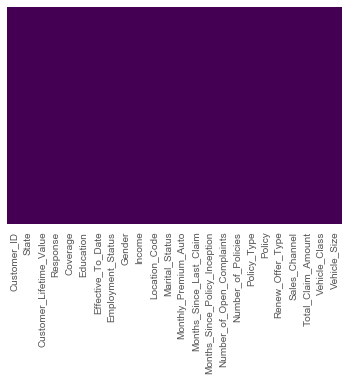

In [27]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [28]:
df.isnull().sum()

Customer_ID                      0
State                            0
Customer_Lifetime_Value          0
Response                         0
Coverage                         0
Education                        0
Effective_To_Date                0
Employment_Status                0
Gender                           0
Income                           0
Location_Code                    0
Marital_Status                   0
Monthly_Premium_Auto             0
Months_Since_Last_Claim          0
Months_Since_Policy_Inception    0
Number_of_Open_Complaints        0
Number_of_Policies               0
Policy_Type                      0
Policy                           0
Renew_Offer_Type                 0
Sales_Channel                    0
Total_Claim_Amount               0
Vehicle_Class                    0
Vehicle_Size                     0
dtype: int64

There is no missing data

# Univariate Analyse

## Hilfsfunktionen

In [29]:
df.Customer_Lifetime_Value.quantile(q=0.75)

8962.1669921875

In [30]:
def univariat_analysis_number(dataframe, column):
    print("*"*100+"\n")
    print(dataframe[column].name.upper()+"\n")
    print("Anzahl Datensätze:\t{}".format(dataframe[column].count()))
    print("Kleinster Betrag:\t{}".format(dataframe[column].min()))
    print("Median:\t\t\t{}".format(dataframe[column].median()))
    print("Durchschnitt:\t\t{0:.2f}".format(dataframe[column].mean()))
    print("Größter Betrag:\t\t{}".format(dataframe[column].max()))

    pd.DataFrame(dataframe[column]).boxplot(figsize=(12,1), vert=False, showfliers=True)
    plt.axvline(x=dataframe[column].mean(), color='blue')
    plt.show()
    
    if dataframe[column].max() >= 3 * dataframe[column].quantile(q=0.75):
        pd.DataFrame(dataframe[column]).boxplot(figsize=(12,1), vert=False, showfliers=False)
        plt.axvline(x=dataframe[column].mean(), color='blue')
        plt.show()

In [66]:
def univariat_analysis_categorical(dataframe, column, kind='bar', figsize=(11,5)):
    print("*"*100+"\n")
    print(dataframe[column].name.upper()+"\n")
    print("Anzahl Datensätze:\t\t\t{}".format(dataframe[column].count()))
    print("Häufigkeit des häufigsten Wertes:\t{}".format(dataframe.groupby(column)[column].count().max()))
    print("Häufigkeit des seltensten Wertes:\t{}".format(dataframe.groupby(column)[column].count().min()))
    ax = dataframe.groupby(column)[column].count().plot(kind=kind, rot=0, figsize=figsize)
    if kind == 'bar':
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() * 1.005))
    plt.ylabel("Anzahl")
    plt.show()

## Numerische Variablen

In [32]:
print(df.select_dtypes(include=np.number).columns)

Index(['Customer_Lifetime_Value', 'Income', 'Monthly_Premium_Auto',
       'Months_Since_Last_Claim', 'Months_Since_Policy_Inception',
       'Number_of_Open_Complaints', 'Number_of_Policies',
       'Total_Claim_Amount'],
      dtype='object')


### Customer Lifetime Value

****************************************************************************************************

CUSTOMER_LIFETIME_VALUE

Anzahl Datensätze:	9134
Kleinster Betrag:	1898.0076904296875
Median:			5780.18212890625
Durchschnitt:		8004.93
Größter Betrag:		83325.3828125


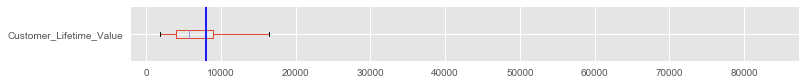

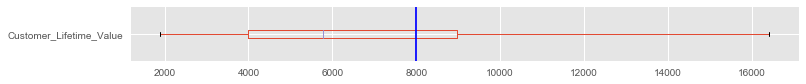

In [33]:
univariat_analysis_number(df, 'Customer_Lifetime_Value')

Mean > Median -> wir haben ein paar heftige Ausreißer, die den Durchschnitt hochziehen.  
Evtl sollte man diese speziell behandeln, wir sollten auf jeden Fall später das Residuals-vs-Leverage-Diagramm anschauen!

### Income

****************************************************************************************************

INCOME

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			33889.5
Durchschnitt:		37657.38
Größter Betrag:		99981


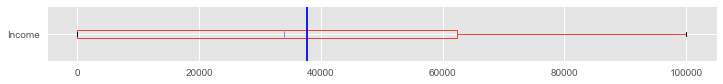

In [34]:
univariat_analysis_number(df, 'Income')

Hier sehen wir einigermaßen eine Normalverteilung, schön.

### Monthly_Premium_Auto

****************************************************************************************************

MONTHLY_PREMIUM_AUTO

Anzahl Datensätze:	9134
Kleinster Betrag:	61
Median:			83.0
Durchschnitt:		93.22
Größter Betrag:		298


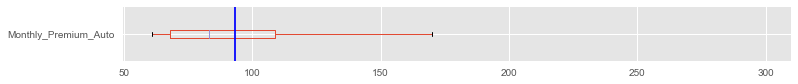

In [35]:
univariat_analysis_number(df, 'Monthly_Premium_Auto')

Auch hier gibt es wieder Ausreißer nach oben, Menschen die das Dreifache des Durchschnitts zahlen.

### Months_Since_Last_Claim

****************************************************************************************************

MONTHS_SINCE_LAST_CLAIM

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			14.0
Durchschnitt:		15.10
Größter Betrag:		35


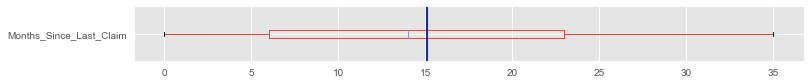

In [36]:
univariat_analysis_number(df, 'Months_Since_Last_Claim')

Hier eine wunderschöne Normalverteilung.

### Months_Since_Policy_Inception

****************************************************************************************************

MONTHS_SINCE_POLICY_INCEPTION

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			48.0
Durchschnitt:		48.06
Größter Betrag:		99


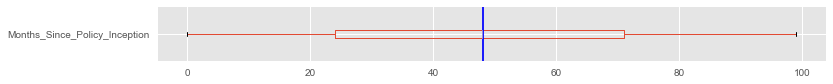

In [37]:
univariat_analysis_number(df, 'Months_Since_Policy_Inception')

Und hier eine nahezu perfekte Normalverteilung.

### Number_of_Open_Complaints

****************************************************************************************************

NUMBER_OF_OPEN_COMPLAINTS

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			0.0
Durchschnitt:		0.38
Größter Betrag:		5


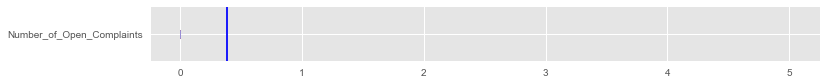

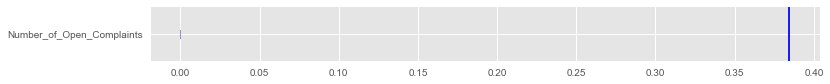

In [38]:
univariat_analysis_number(df, 'Number_of_Open_Complaints')

Wir sehen schon keine Box mehr - es gibt fast keine offenen Beschwerden:

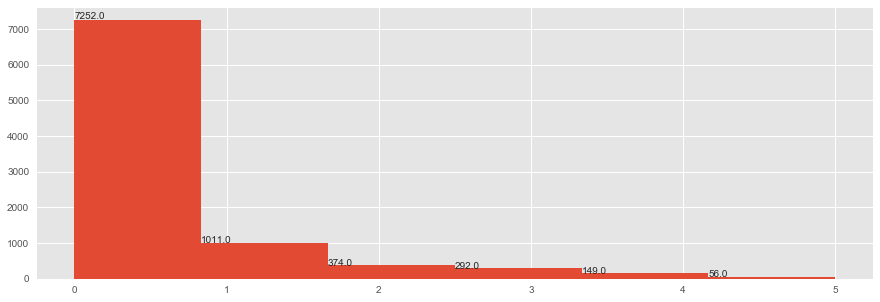

In [39]:
ax = df.Number_of_Open_Complaints.hist(figsize=(15,5), bins=df.Number_of_Open_Complaints.nunique())
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.005))
plt.show()

### Number_of_Policies

****************************************************************************************************

NUMBER_OF_POLICIES

Anzahl Datensätze:	9134
Kleinster Betrag:	1
Median:			2.0
Durchschnitt:		2.97
Größter Betrag:		9


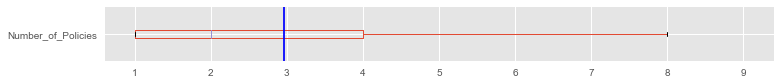

In [40]:
univariat_analysis_number(df, 'Number_of_Policies')

### Total_Claim_Amount

****************************************************************************************************

TOTAL_CLAIM_AMOUNT

Anzahl Datensätze:	9134
Kleinster Betrag:	0.0990070030093193
Median:			383.9454345703125
Durchschnitt:		434.09
Größter Betrag:		2893.23974609375


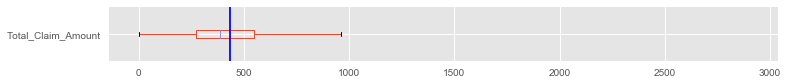

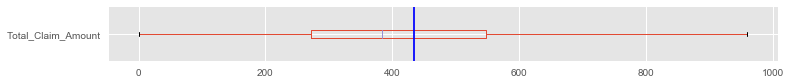

In [41]:
univariat_analysis_number(df, 'Total_Claim_Amount')

## Kategoriale Variablen

Wir schauen uns "wichtige" Variablen einzeln an, dann den Rest gemeinsam.

In [89]:
categorical_columns = df.select_dtypes(include="category").columns.tolist()

### Response

****************************************************************************************************

RESPONSE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	7826
Häufigkeit des seltensten Wertes:	1308


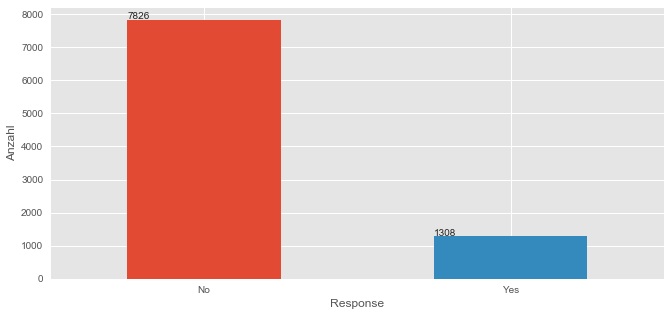

Anteil der Rückmeldungen:	0.14320122618786948


In [96]:
column = 'Response'
univariat_analysis_categorical(df, column)
print("Anteil der Rückmeldungen:\t{}".format(df[column].value_counts()['Yes']/df[column].count()))
if column in categorical_columns: categorical_columns.remove(column)

Wir sehen: wir haben 14% Rückmeldungen. Dies ist für eine Marketingmaßnahme generell nicht als schlecht anzusehen.  
Nachdem ```Response``` unsere Zielvariable für die Klassifikation ist, sehen wir hier allerdings Probleme auf uns zukommen, da ein hoher Bias vorliegt.

### Unemployed

****************************************************************************************************

EMPLOYMENT_STATUS

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5698
Häufigkeit des seltensten Wertes:	282


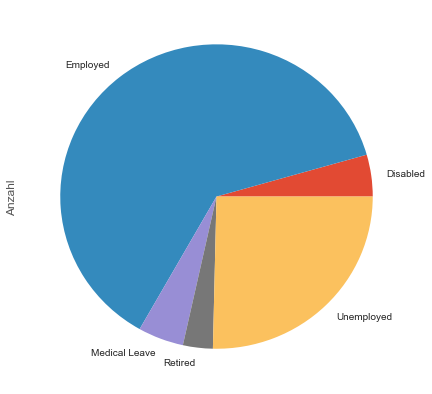

Anteil der Arbeitslosen:	0.25366761550251804


In [97]:
column = 'Employment_Status'
univariat_analysis_categorical(df, column, 'pie', (7,7))
print("Anteil der Arbeitslosen:\t{}".format(df[column].value_counts()['Unemployed']/df[column].count()))
if column in categorical_columns: categorical_columns.remove(column)

Interessant ist zu beobachten, dass wir einen Arbeitslosenanteil von 25% haben - speziell, wenn man auch den ```Policy_Type``` betrachtet:

### Policy_Type

****************************************************************************************************

POLICY_TYPE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	6788
Häufigkeit des seltensten Wertes:	378


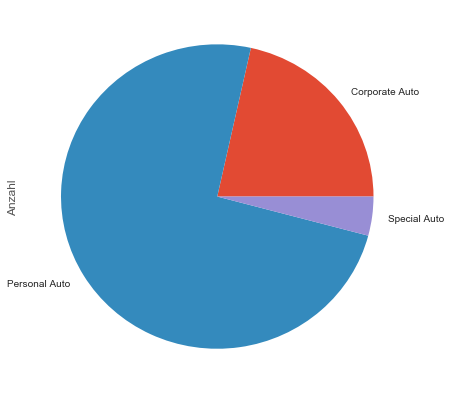

Anteil der Firmenwägen:	0.2154587256404642


In [101]:
column = 'Policy_Type'
univariat_analysis_categorical(df, column, 'pie', (7,7))
print("Anteil der Firmenwägen:\t{}".format(df[column].value_counts()['Corporate Auto']/df[column].count()))
if column in categorical_columns: categorical_columns.remove(column)

Wir sehen: 22% der versicherten Autos sind Firmenwägen - kommt es eventuell zu Überschneidungen zwischen Firmenwägen und Arbeitslosen? Dieser Frage werden wir bei den bivariaten Analysen nachgehen.

### Weitere Variablen

****************************************************************************************************

STATE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3150
Häufigkeit des seltensten Wertes:	798


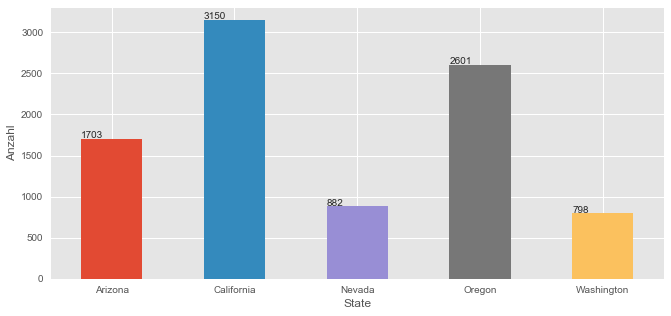

****************************************************************************************************

COVERAGE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5568
Häufigkeit des seltensten Wertes:	824


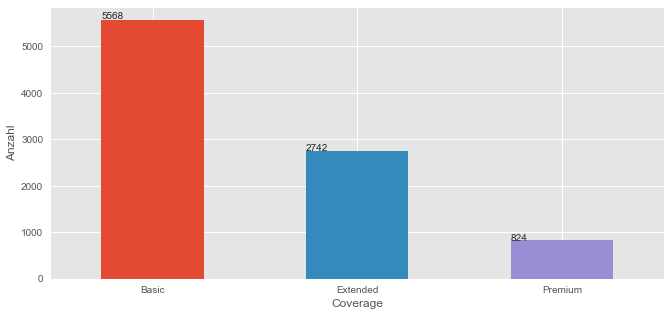

****************************************************************************************************

EDUCATION

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	2748
Häufigkeit des seltensten Wertes:	342


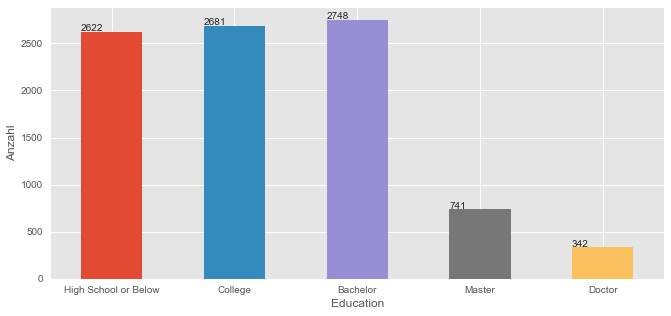

****************************************************************************************************

GENDER

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	4658
Häufigkeit des seltensten Wertes:	4476


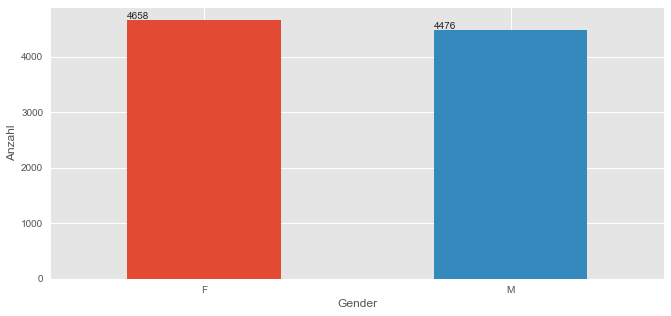

****************************************************************************************************

LOCATION_CODE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5779
Häufigkeit des seltensten Wertes:	1582


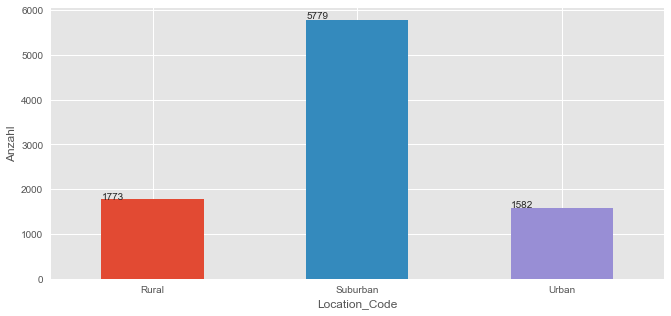

****************************************************************************************************

MARITAL_STATUS

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5298
Häufigkeit des seltensten Wertes:	1369


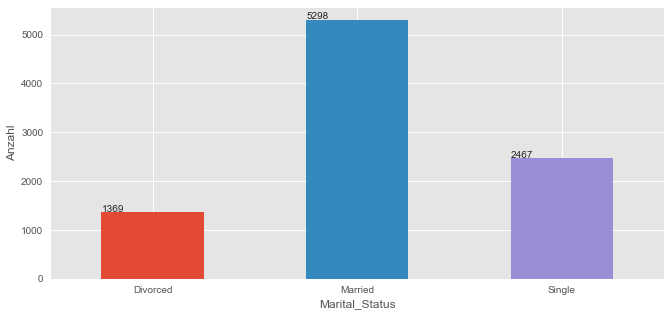

****************************************************************************************************

POLICY

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3426
Häufigkeit des seltensten Wertes:	66


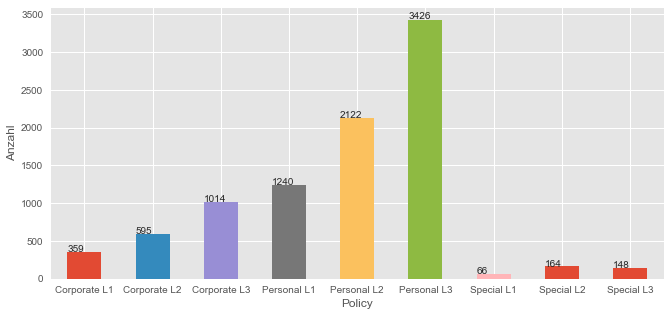

****************************************************************************************************

RENEW_OFFER_TYPE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3752
Häufigkeit des seltensten Wertes:	1024


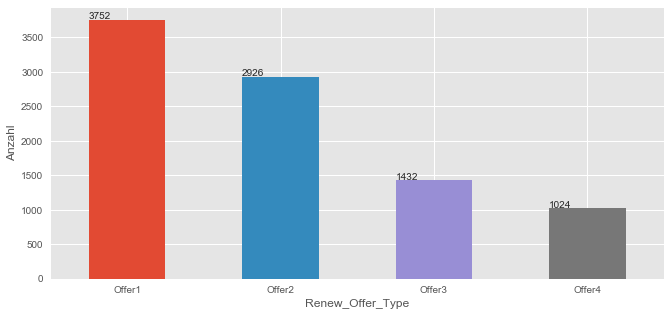

****************************************************************************************************

SALES_CHANNEL

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3477
Häufigkeit des seltensten Wertes:	1325


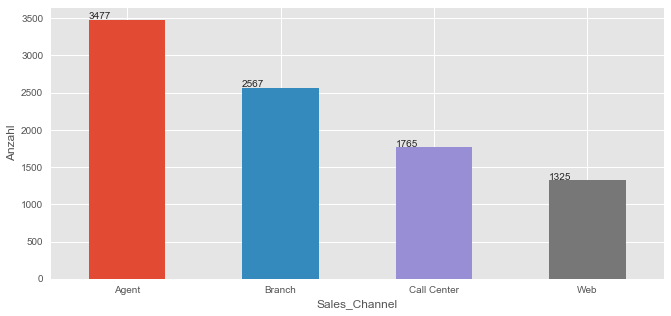

****************************************************************************************************

VEHICLE_CLASS

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	4621
Häufigkeit des seltensten Wertes:	163


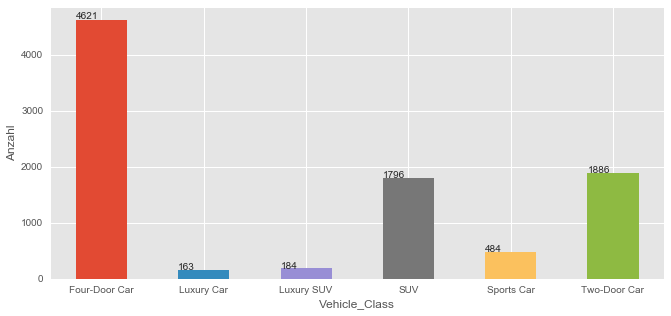

****************************************************************************************************

VEHICLE_SIZE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	6424
Häufigkeit des seltensten Wertes:	946


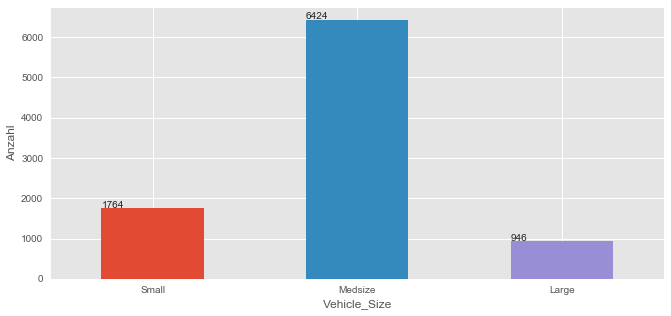

In [102]:
for column in categorical_columns:
    univariat_analysis_categorical(df, column)

## Timestamp

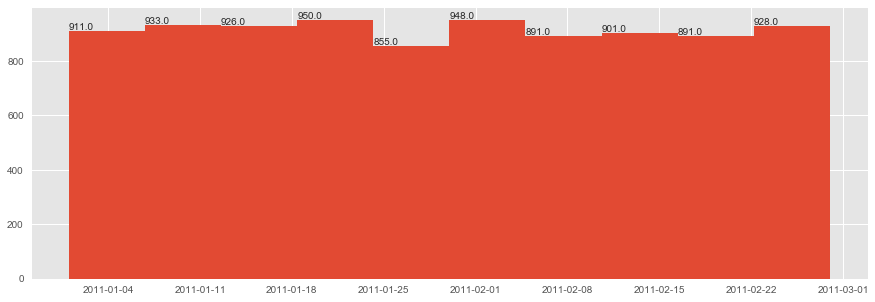

In [103]:
ax = df.Effective_To_Date.hist(figsize=(15,5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() * 1.005))
plt.show()

Wir sehen: der Datenbestand umfasst zwei Monate.  
Daraus folgt:  
+ Eine Zeitreihenanalyse ergibt für diesen kurzen Zeitraum keinen Sinn.
+ Die Enddaten der Policen sind gleichverteilt, man kann also auch keinen Peak oder ähnliches zu Jahresbeginn feststellen.

# Bi- und evtl multivariate Analysen

## Scatterplot

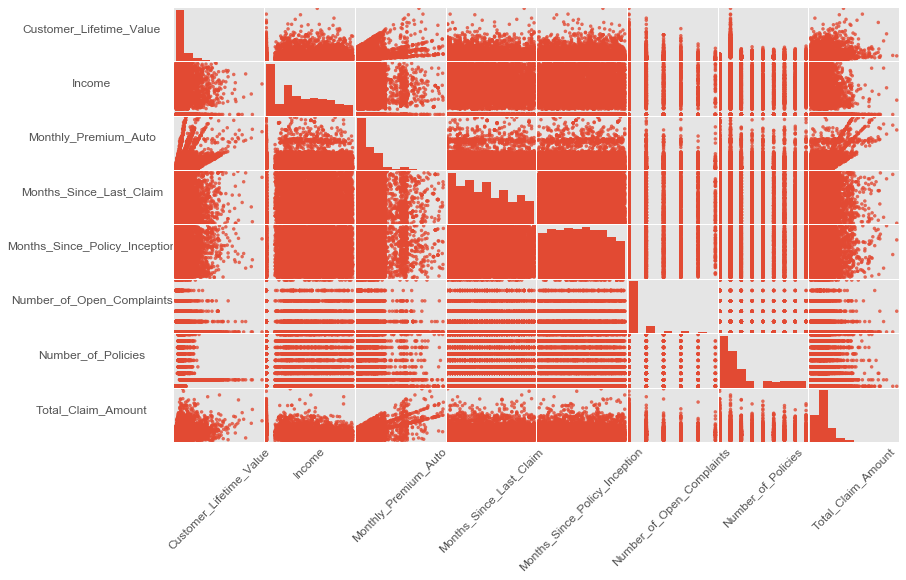

In [107]:
sm = pd.plotting.scatter_matrix(df, alpha=0.8, figsize=(13, 8), diagonal='hist')
#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.9,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

## Korrelations-Matrix

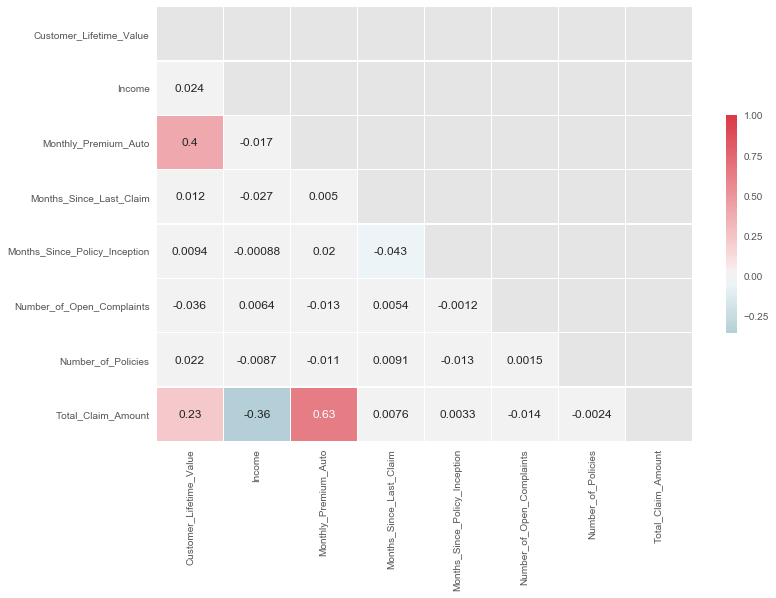

In [108]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, annot_kws={"size": 12}, square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Oh, ist blöd. Wir machen aus den Kategorien ints und berechnen erneut:

In [109]:
df_for_corr = df.copy()

df_for_corr.Coverage.cat.categories = [0,1,2]
df_for_corr.Coverage = df_for_corr.Coverage.astype('uint8')

df_for_corr.Education.cat.categories = [0,1,2,3,4]
df_for_corr.Education = df_for_corr.Education.astype('uint8')

df_for_corr.Vehicle_Size.cat.categories = [0,1,2]
df_for_corr.Vehicle_Size = df_for_corr.Vehicle_Size.astype('uint8')

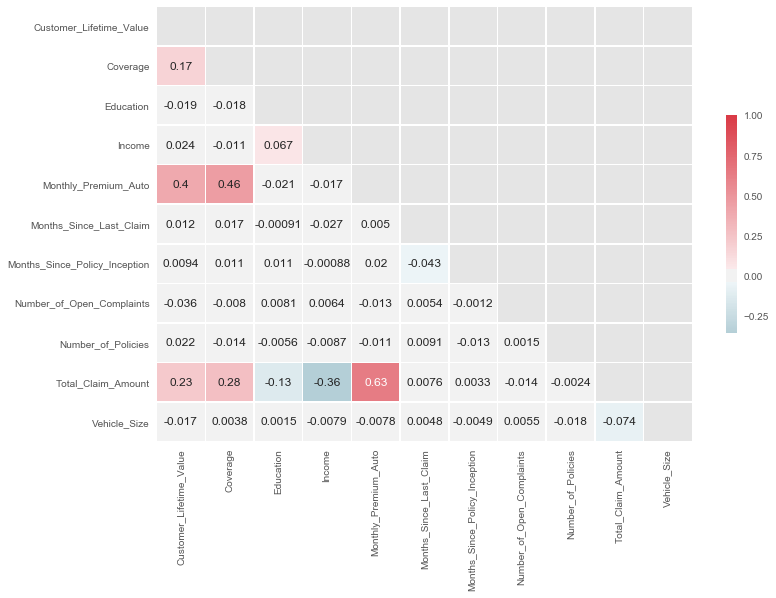

In [105]:
corr = df_for_corr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, annot_kws={"size": 12}, square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Zusammenhang mit Zielvariablen für Klassifikation

Weil ja Zielvariable nominal und damit nicht in Korrelation enthalten, hier so mit visuell.

In [274]:
num_columns_for_corr = df.select_dtypes(include=np.number).columns.tolist()
cat_columns_for_corr = df.select_dtypes(include="category").columns.tolist()
cat_columns_for_corr.remove('Response')

### Numerische Variablen

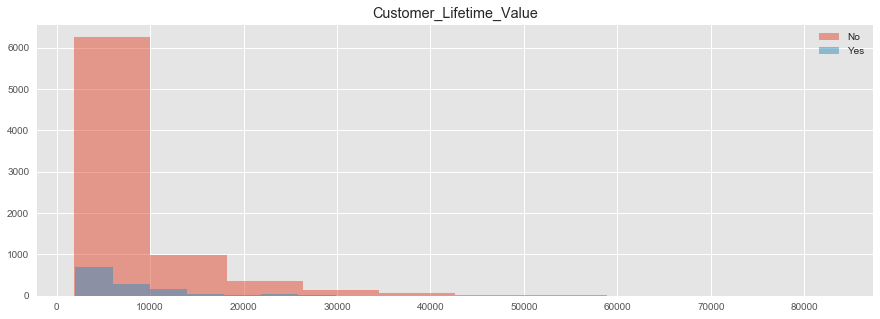

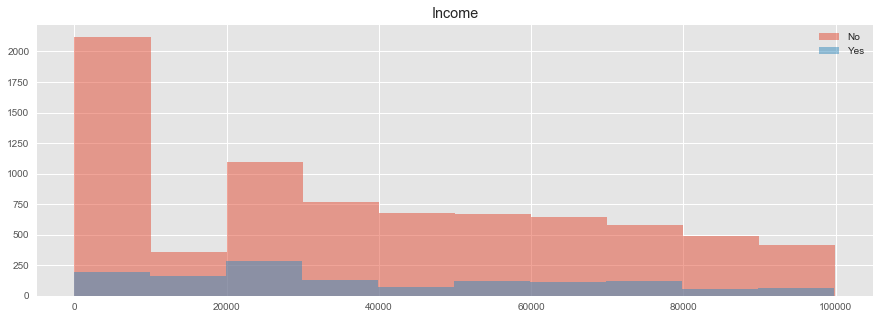

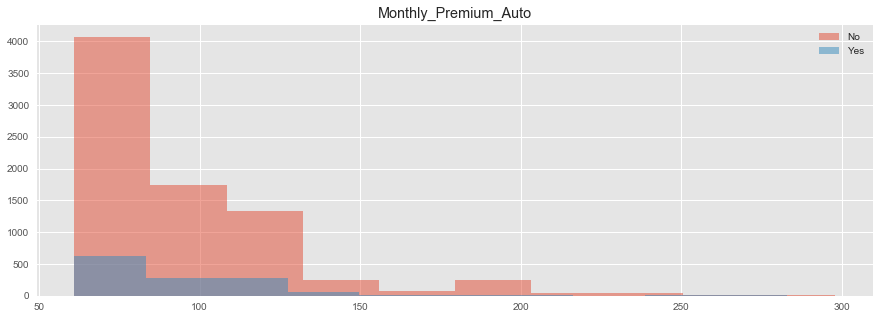

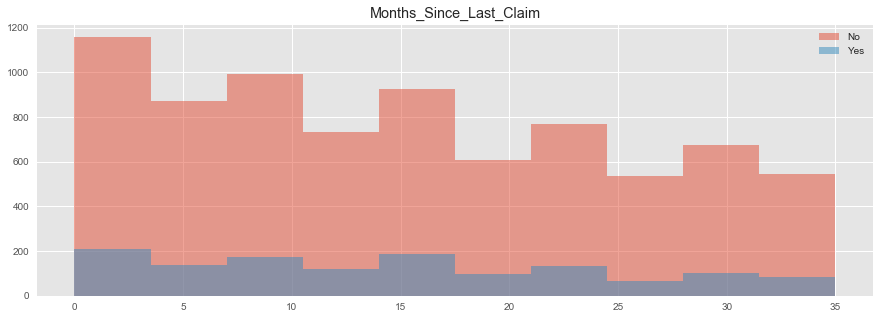

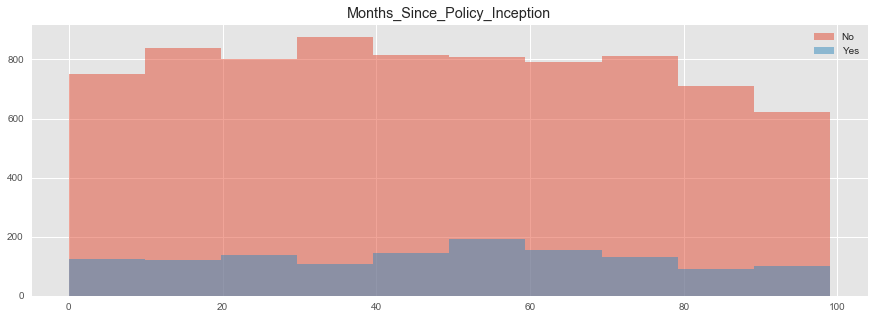

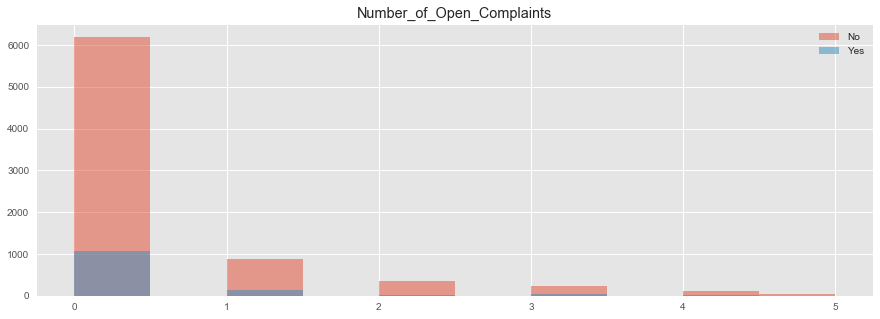

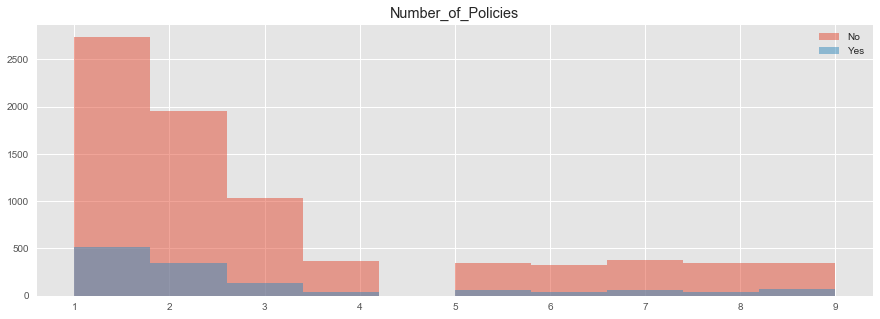

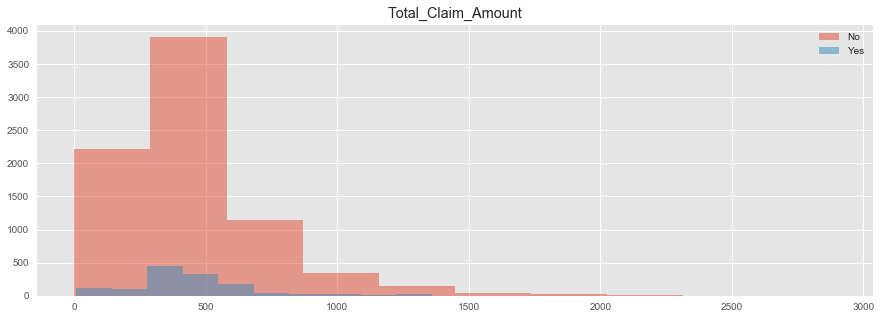

In [282]:
for column in num_columns_for_corr:
    groups = df.groupby('Response')[column]
    fig, ax = plt.subplots()
    for group, variable in groups:
        variable.hist(label=group, alpha=.5, ax=ax, figsize=(15,5))
    ax.legend()
    plt.title(column)

### Kategoriale Variablen

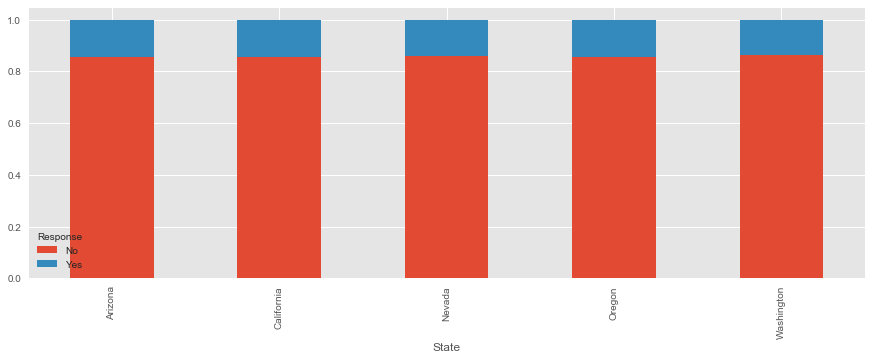

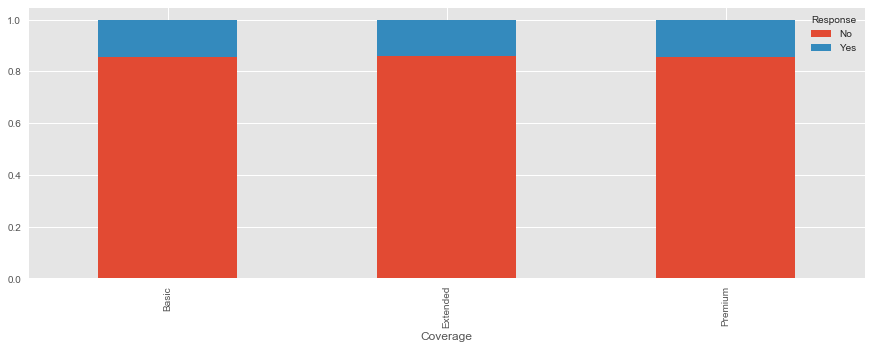

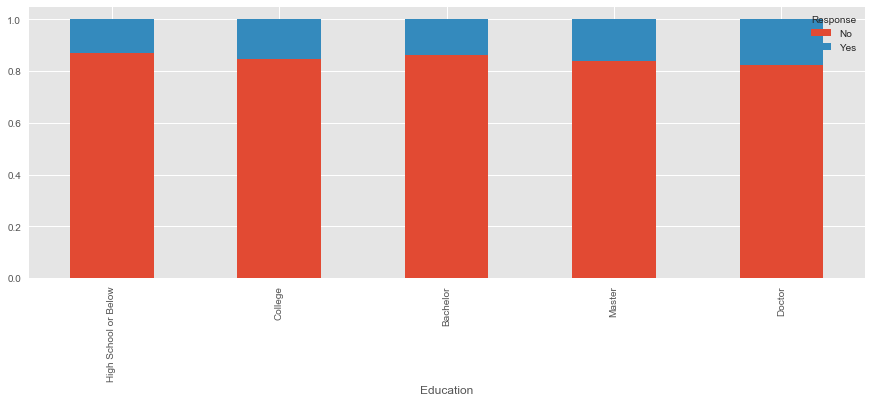

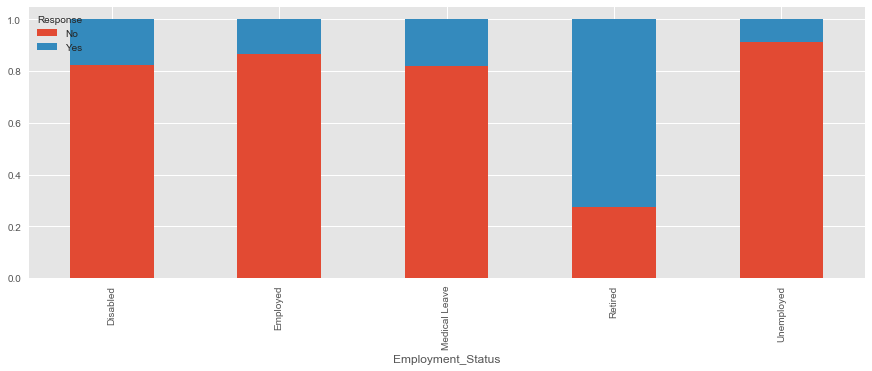

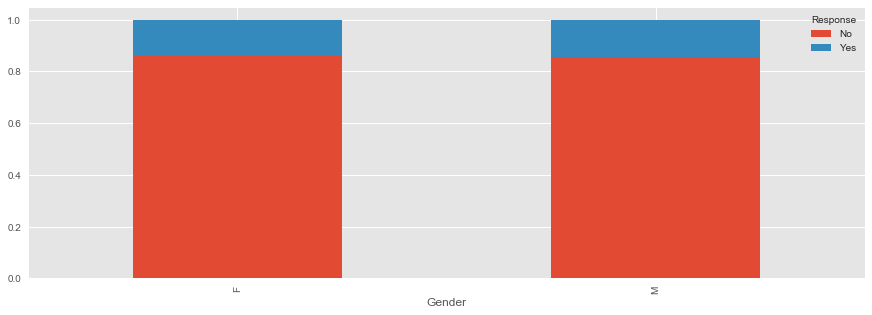

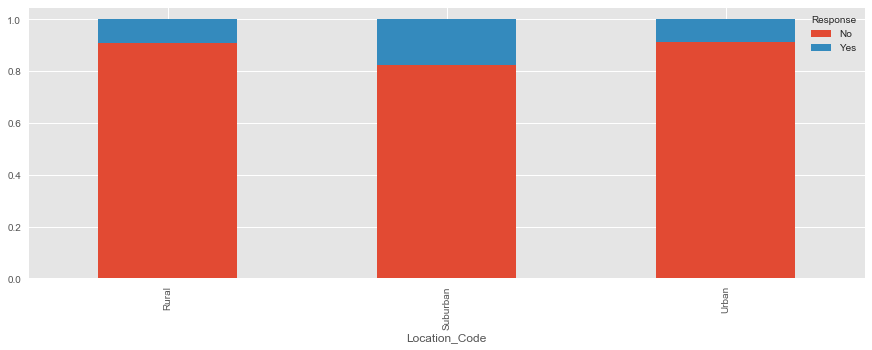

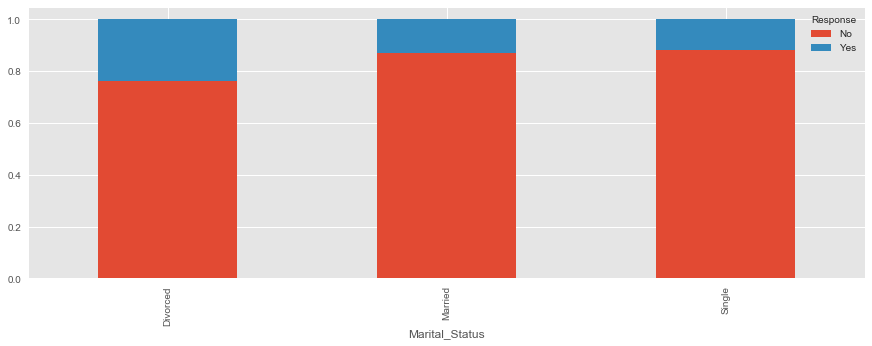

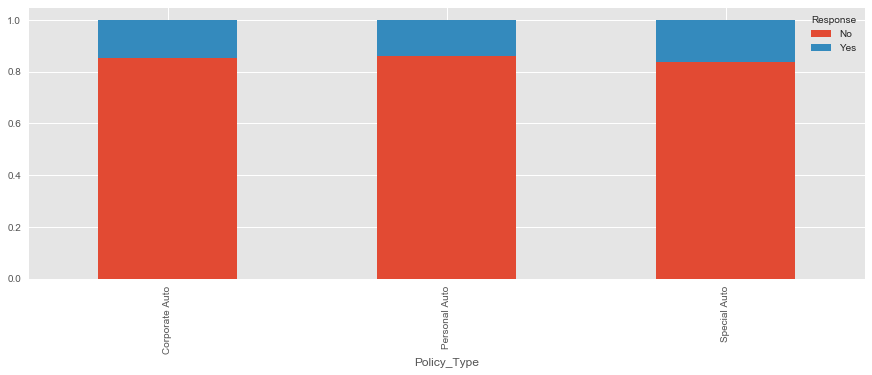

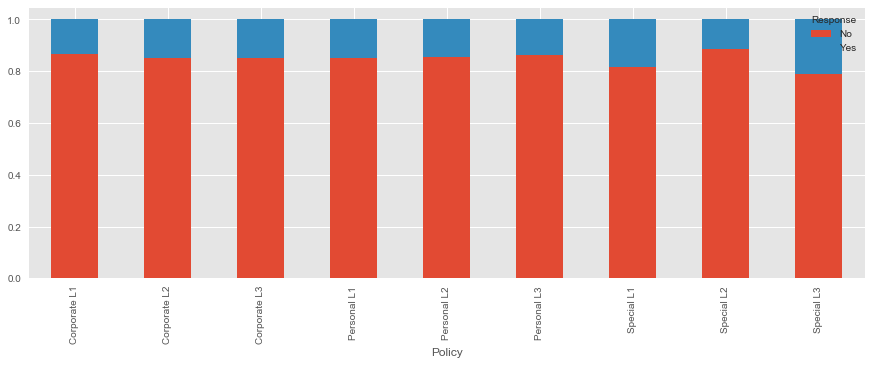

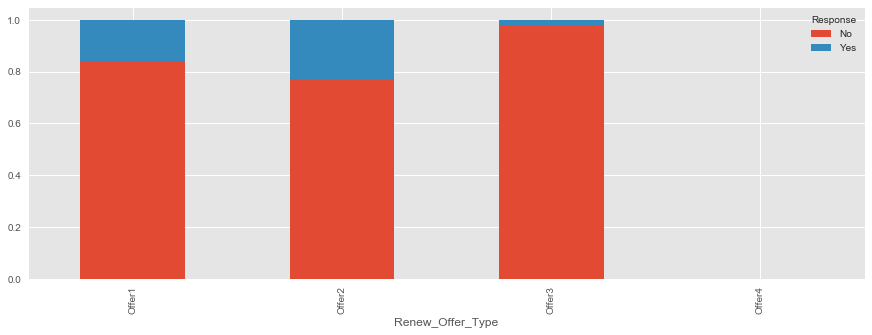

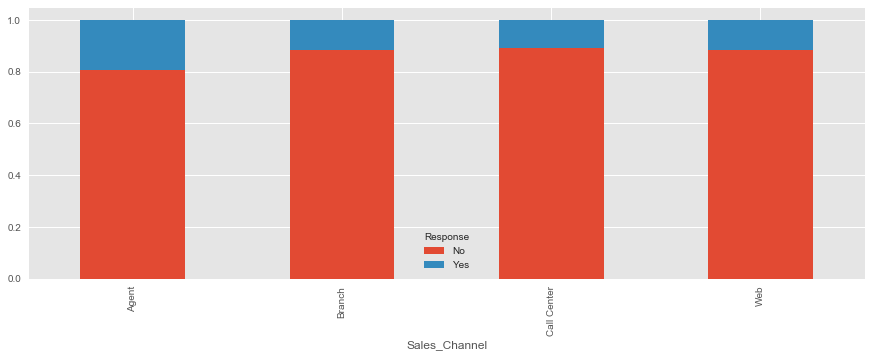

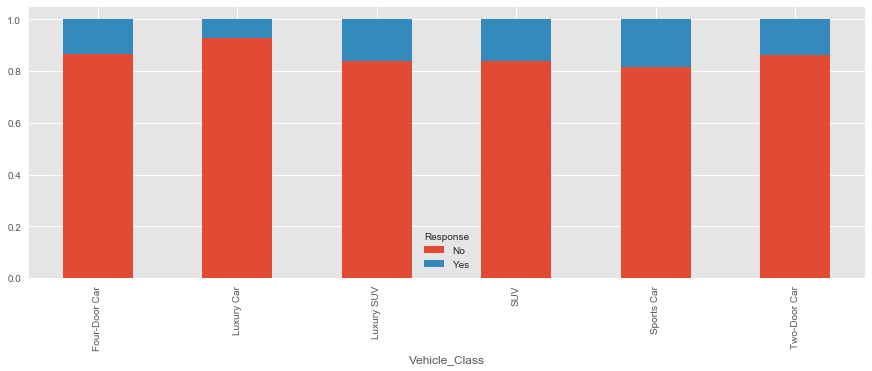

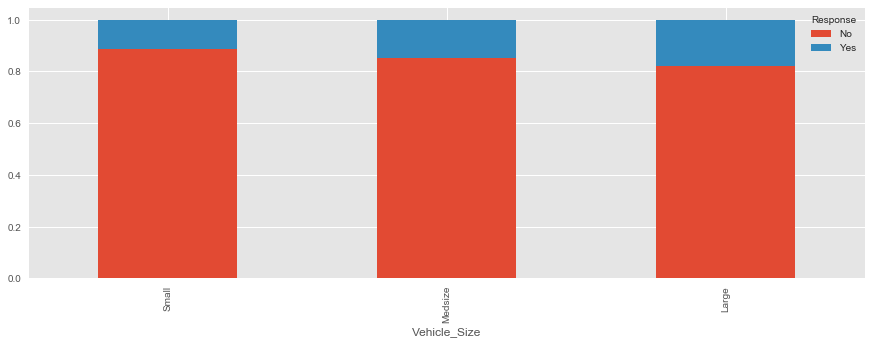

In [281]:
for column in cat_columns_for_corr:
    plot_df = pd.DataFrame(df.groupby(by=[column, 'Response'])['Customer_ID'].count()).unstack()
    plot_df.columns = plot_df.columns.droplevel()
    plot_df.columns = plot_df.columns.astype('object')
    plot_df['total'] = plot_df.apply(lambda row: row.Yes+row.No, axis=1)
    plot_df.Yes = plot_df.apply(lambda row: row.Yes / row.total, axis=1)
    plot_df.No = plot_df.apply(lambda row: row.No / row.total, axis=1)
    plot_df.drop(columns='total', inplace=True)
    plot_df.plot(kind='bar', stacked=True, figsize=(15,5))

# Transform Data

# Visualize data
Once you have tidy data with the variables you need, there are two main engines of knowledge generation: visualisation and modelling. These have complementary strengths and weaknesses so any real analysis will iterate between them many times.

+ Boxplots
+ Histogramme
+ Scatter (e.g. Gender Distribution, Income in Bezug auf Ausgaben und Geschlecht, Income in Bezug auf Total_Claim_Account)
+ Gender: Verhalten im Bezug auf den Mariat_Status, Was für ein AutoType hat welches Geschlecht? => neue Variable
+ Karte mit den States mit einbauen, Anteile anzeigen, Berufsbildung, => es geht hier um eine Marketinganalyse
+ Durchschnittlicher Spending
+ Kategorisierem der Autos in einer neuen unique Variablen 

**Visualisation** is a fundamentally human activity. A good visualisation will show you things that you did not expect, or raise new questions about the data. A good visualisation might also hint that you’re asking the wrong question, or you need to collect different data. Visualisations can surprise you, but don’t scale particularly well because they require a human to interpret them.

# Models
**Models** are complementary tools to visualisation. Once you have made your questions sufficiently precise, you can use a model to answer them. Models are a fundamentally mathematical or computational tool, so they generally scale well. But every model makes assumptions, and by its very nature a model cannot question its own assumptions. That means a model cannot fundamentally surprise you.

# Communication
The last step is **communication**, an absolutely critical part of any data analysis project. It doesn’t matter how well your models and visualisation have led you to understand the data unless you can also communicate your results to others.

Surrounding all these tools is **programming**. Programming is a cross-cutting tool that you use in every part of the project. You don’t need to be an expert programmer to be a data scientist, but learning more about programming pays off because becoming a better programmer allows you to automate common tasks, and solve new problems with greater ease.

Source: Wickham/Grolemund, 2016